In [ ]:
%pip uninstall tensorflow tensorflow-intel -y
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
# --- Install dependencies (run once) ---
# !pip install pandas numpy scikit-learn sentence-transformers joblib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
import joblib

# === Step 1: Load and Clean Data ===
df = pd.read_csv("Data_Breaches_K.csv")
df = df.dropna(subset=["Type of breach", "Sector", "Severity", "Year of Breach", "Records Exposed"])

df["Year of Breach"] = pd.to_numeric(df["Year of Breach"], errors='coerce')
df["Records Exposed"] = pd.to_numeric(df["Records Exposed"], errors='coerce')
df = df.dropna(subset=["Year of Breach", "Records Exposed"])

# === Step 2: Encode and Scale ===
le_sector = LabelEncoder()
df["Sector_encoded"] = le_sector.fit_transform(df["Sector"])

scaler_year = MinMaxScaler()
scaler_records = MinMaxScaler()

df["Year_scaled"] = scaler_year.fit_transform(df[["Year of Breach"]])
df["Records_scaled"] = scaler_records.fit_transform(df[["Records Exposed"]])

# === Step 3: BERT Embeddings for Type of Breach ===
import os
os.environ["USE_TF"] = "0"
os.environ["USE_TORCH"] = "1"
os.environ["TRANSFORMERS_NO_TF_WARNING"] = "1"

bert_model = SentenceTransformer("all-MiniLM-L6-v2")
bert_embeddings = bert_model.encode(df["Type of breach"].tolist(), convert_to_numpy=True)

# === Step 4: Combine Features ===
X = np.concatenate(
    [bert_embeddings,
     df[["Sector_encoded", "Year_scaled", "Records_scaled"]].values],
    axis=1
)

# === Step 5: Encode Target ===
le_severity = LabelEncoder()
y = le_severity.fit_transform(df["Severity"])

# === Step 6: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Step 7: Random Forest Model ===
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

# === Step 8: Evaluation ===
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Random Forest Accuracy: {acc:.3f}\n")
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_severity.classes_))
print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === Step 9: Save Models ===
joblib.dump(rf, "rf_model.pkl")
joblib.dump(le_sector, "le_sector.pkl")
joblib.dump(le_severity, "le_severity.pkl")
joblib.dump(scaler_year, "scaler_year.pkl")
joblib.dump(scaler_records, "scaler_records.pkl")
bert_model.save("bert_model")

print("✅ All models and encoders saved successfully.")


c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


✅ Random Forest Accuracy: 0.913

📊 Classification Report:
              precision    recall  f1-score   support

        High       0.95      0.94      0.94       575
         Low       0.80      0.85      0.82        80
      Medium       0.84      0.85      0.85       169

    accuracy                           0.91       824
   macro avg       0.86      0.88      0.87       824
weighted avg       0.91      0.91      0.91       824


🧩 Confusion Matrix:
[[540  17  18]
 [  3  68   9]
 [ 25   0 144]]
✅ All models and encoders saved successfully.


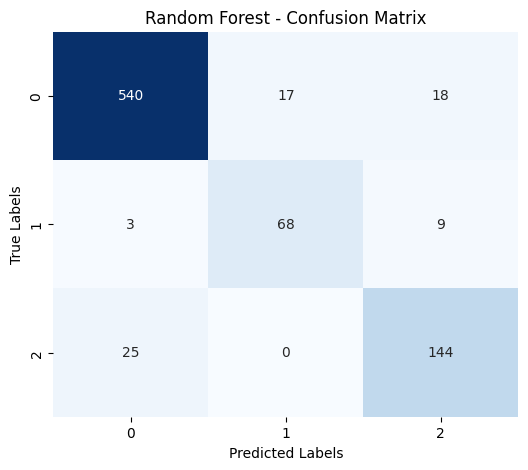

c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

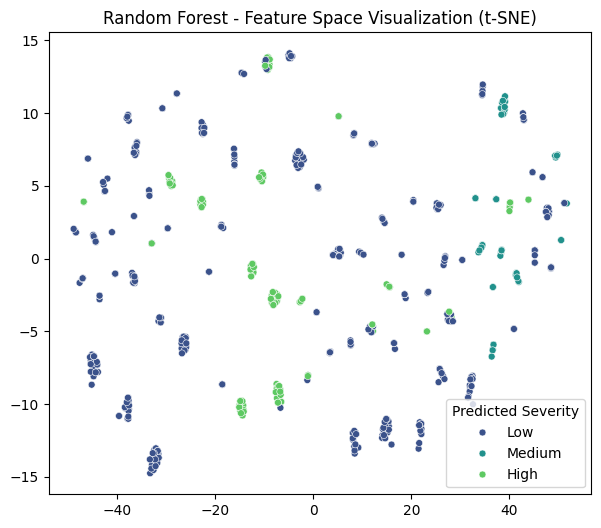

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

# --- Confusion Matrix ---
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# --- t-SNE Visualization of Features ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_test) 

plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    hue=[["Low", "Medium", "High"][i] for i in y_pred],
    palette='viridis',
    s=25
)
plt.title("Random Forest - Feature Space Visualization (t-SNE)")
plt.legend(title="Predicted Severity")
plt.show()


In [5]:
import os
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import joblib

# --- Load saved components ---
os.environ["USE_TF"] = "0"
os.environ["USE_TORCH"] = "1"
os.environ["TRANSFORMERS_NO_TF_WARNING"] = "1"

rf = joblib.load("rf_model.pkl")
le_sector = joblib.load("le_sector.pkl")
le_severity = joblib.load("le_severity.pkl")
scaler_year = joblib.load("scaler_year.pkl")
scaler_records = joblib.load("scaler_records.pkl")
bert_model = SentenceTransformer("all-MiniLM-L6-v2")

# --- Example input ---
new_data = pd.DataFrame({
    "Type of breach": ["IT"],
    "Sector": ["HEAL"],
    "Year of Breach": [2020],
    "Records Exposed": [12000]
})

# --- Preprocess ---
new_data["Sector_encoded"] = le_sector.transform(new_data["Sector"])
new_data["Year_scaled"] = scaler_year.transform(new_data[["Year of Breach"]])
new_data["Records_scaled"] = scaler_records.transform(new_data[["Records Exposed"]])

bert_embedding = bert_model.encode(new_data["Type of breach"].tolist(), convert_to_numpy=True)

X_new = np.concatenate(
    [bert_embedding,
     new_data[["Sector_encoded", "Year_scaled", "Records_scaled"]].values],
    axis=1
)

# --- Predict ---
y_pred = rf.predict(X_new)
predicted_label = le_severity.inverse_transform(y_pred)

print(f"🔍 Predicted Severity: {predicted_label[0]}")


c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


🔍 Predicted Severity: High


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sentence_transformers import SentenceTransformer
import joblib

# Load data
df = pd.read_csv("Data_Breaches_K.csv")

# Clean
df = df.dropna(subset=["Company", "Type of breach", "Sector", "Severity", "Year of Breach", "Records Exposed"])
df["Year of Breach"] = pd.to_numeric(df["Year of Breach"], errors='coerce')
df["Records Exposed"] = pd.to_numeric(df["Records Exposed"], errors='coerce')
df = df.dropna(subset=["Year of Breach", "Records Exposed"])

# --- Text embeddings for breach type ---
import os
os.environ["USE_TF"] = "0"
os.environ["USE_TORCH"] = "1"
os.environ["TRANSFORMERS_NO_TF_WARNING"] = "1"

bert_model = SentenceTransformer("all-MiniLM-L6-v2")
type_embeddings = bert_model.encode(df["Type of breach"].tolist(), convert_to_numpy=True)
df_emb = pd.DataFrame(type_embeddings)
df = pd.concat([df.reset_index(drop=True), df_emb], axis=1)

# --- Company-level aggregation ---
agg_funcs = {
    "Records Exposed": ["mean", "max", "sum", "count"],
    "Year of Breach": ["min", "max"],
}

# Aggregate numeric + embeddings by company
company_features = (
    df.groupby("Company")
      .agg({**agg_funcs, **{i: "mean" for i in df_emb.columns}})
)

company_features.columns = [
    "_".join(map(str, col)).strip() for col in company_features.columns
]

# Encode sector (most frequent sector per company)
sector_map = df.groupby("Company")["Sector"].agg(lambda x: x.value_counts().index[0])
company_features["Sector"] = sector_map

le_sector = LabelEncoder()
company_features["Sector_encoded"] = le_sector.fit_transform(company_features["Sector"])

# Encode target: if company ever had a High severity breach
company_risk = (
    df.groupby("Company")["Severity"]
      .apply(lambda x: 1 if "High" in x.values else 0)
)

company_features["HighRiskFuture"] = company_risk

print("✅ Company-level feature matrix ready:", company_features.shape)


c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


✅ Company-level feature matrix ready: (3880, 393)


C:\Users\kumar\AppData\Local\Temp\ipykernel_13544\2975325083.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  company_features["Sector"] = sector_map
C:\Users\kumar\AppData\Local\Temp\ipykernel_13544\2975325083.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  company_features["Sector_encoded"] = le_sector.fit_transform(company_features["Sector"])
C:\Users\kumar\AppData\Local\Temp\ipykernel_13544\2975325083.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

In [3]:
# Split features and target
X = company_features.drop(columns=["HighRiskFuture", "Sector"])
y = company_features["HighRiskFuture"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf_risk = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42
)
rf_risk.fit(X_train, y_train)

# Evaluate
y_pred = rf_risk.predict(X_test)
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred, target_names=["Low Risk", "High Risk"]))

# Save
joblib.dump(rf_risk, "company_risk_model.pkl")
joblib.dump(le_sector, "sector_encoder.pkl")
print("✅ Risk model saved.")


✅ Accuracy: 0.795
              precision    recall  f1-score   support

    Low Risk       0.61      0.84      0.71       228
   High Risk       0.92      0.78      0.84       548

    accuracy                           0.80       776
   macro avg       0.77      0.81      0.77       776
weighted avg       0.83      0.80      0.80       776

✅ Risk model saved.


In [4]:
# Example: predict future risk for a company
company_name = "MailMyPrescriptions.com"  # replace with actual name

if company_name not in company_features.index:
    print("❌ Company not found in training data.")
else:
    X_company = company_features.loc[[company_name]].drop(columns=["HighRiskFuture", "Sector"])
    risk_prob = rf_risk.predict_proba(X_company)[0, 1]
    risk_label = "High Future Breach Risk" if risk_prob >= 0.5 else "Low Future Breach Risk"
    print(f"🏢 {company_name}: {risk_label} (Probability = {risk_prob:.2f})")


🏢 MailMyPrescriptions.com: Low Future Breach Risk (Probability = 0.37)
